<a href="https://colab.research.google.com/github/E-Fung/Classification_PCD/blob/main/PCD_Model_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INITIALIZE LIBRARIES AND MODEL NAMES**

In [1]:
#########################################################################################################################################################################
#   Initialize libraries and such
#########################################################################################################################################################################

%tensorflow_version 2.x  # this line is not required unless you are in a notebook
from __future__ import absolute_import, division, print_function, unicode_literals
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import io
import os


# Print versions
!python --versions
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

tflite_model_name = 'PCD_Model'
c_model_name = 'PCD_Model'

#This is for gathering the metrics (accuracy % loss) for another set of values
class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

#########################################################################################################################################################################

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
unknown option --versions
usage: python3 [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.
Numpy 1.19.5
TensorFlow 2.4.1
Keras 2.4.0


# **UPLOADING DATA**

In [6]:
#########################################################################################################################################################################
#   Uploading Files
#########################################################################################################################################################################

file_name = 'data_n05' #Change this to the name of the csv file you are uploading
uploaded = files.upload()
pd.read_csv(io.StringIO(uploaded[file_name+'.csv'].decode('utf-8')))

#########################################################################################################################################################################

Saving data_n05.csv to data_n05.csv


,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,Class
0,-54.43,-9.85,-25.84,-151.32,15.80,26.86,-133.73,-26.94,12.42,-72.32,-30.98,6.95,0
1,-53.72,-10.31,-25.93,-150.96,16.49,27.05,-133.44,-26.98,12.71,-72.28,-30.92,7.66,0
2,-53.24,-10.59,-25.99,-150.69,16.83,27.21,-133.19,-27.19,13.33,-72.37,-31.02,8.77,0
3,-52.69,-10.92,-26.21,-150.40,17.08,27.38,-132.98,-27.35,13.80,-72.45,-31.20,9.56,0
4,-52.04,-11.24,-26.75,-149.88,17.49,27.73,-132.67,-27.52,14.27,-72.64,-31.29,10.56,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12851,82.23,-22.88,-18.01,-17.48,26.27,21.33,-131.02,-15.81,24.17,-28.80,-31.79,7.93,4
12852,82.66,-23.01,-17.63,-17.57,26.28,20.69,-130.62,-15.74,23.64,-28.21,-31.39,7.75,4
12853,83.28,-23.26,-17.06,-17.57,26.10,20.46,-130.38,-15.79,23.38,-27.41,-31.41,7.66,4
12854,83.31,-23.03,-16.90,-17.54,25.92,20.34,-130.21,-16.04,23.20,-26.54,-31.76,7.52,4


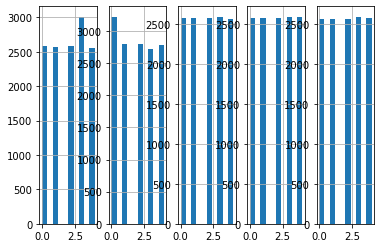

In [7]:
#Verify that the data files are unique and have around the same data for each posture
dd1 = 'data_n01'
dd2 = 'data_n02'
dd3 = 'data_n03'
dd4 = 'data_n04'
dd5 = 'data_n05'
imp_dd1 = pd.read_csv(dd1+'.csv')
imp_dd2 = pd.read_csv(dd2+'.csv')
imp_dd3 = pd.read_csv(dd3+'.csv')
imp_dd4 = pd.read_csv(dd4+'.csv')
imp_dd5 = pd.read_csv(dd5+'.csv')
plt.subplot(1,5,1)
imp_dd1.Class.hist()
plt.subplot(1,5,2)
imp_dd2.Class.hist()
plt.subplot(1,5,3)
imp_dd3.Class.hist()
plt.subplot(1,5,4)
imp_dd4.Class.hist()
plt.subplot(1,5,5)
imp_dd5.Class.hist()

# **DATA PROCESSING**

In [8]:
#########################################################################################################################################################################
#   This block of code is for processing the data, made into a function to implement n-fold cross validation
#########################################################################################################################################################################

def get_data(i):

  #Change these
  train_row_increments = 5
  test_row_increments = 5

  #Initialize variables
  data_arr = ['data_n01','data_n02','data_n03','data_n04','data_n05']
  test_data = data_arr[i]
  data_arr.remove(data_arr[i])
  train_data_01 = data_arr[0]
  train_data_02 = data_arr[1]
  train_data_03 = data_arr[2]
  train_data_04 = data_arr[3]

  #Initialize dataframes for storing the data and combine them 
  train_data1 = pd.read_csv(train_data_01+'.csv')
  train_data2 = pd.read_csv(train_data_02+'.csv')
  train_data3 = pd.read_csv(train_data_03+'.csv')
  train_data4 = pd.read_csv(train_data_04+'.csv')
  train_data_combined = pd.concat([train_data1,train_data2,train_data3,train_data4],ignore_index=True)

  #Process the data::
  train_data_sampled = train_data_combined[1::train_row_increments]#sample every few rows to improve training data (IMUs give data very frequently so the data is very similar)
  data_shuffled = train_data_sampled.sample(frac=1).reset_index(drop=True)#shuffle it
  d0 = data_shuffled.loc[data_shuffled['Class'] == 0]#split the data by their posture, the data remains ordered (post shuffle)
  d1 = data_shuffled.loc[data_shuffled['Class'] == 1]
  d2 = data_shuffled.loc[data_shuffled['Class'] == 2]
  d3 = data_shuffled.loc[data_shuffled['Class'] == 3]
  d4 = data_shuffled.loc[data_shuffled['Class'] == 4]
  min_class = min(len(d0),len(d1),len(d2),len(d3),len(d4))
  d0_split = d0.sample(frac=(min_class/len(d0)),random_state=1) #slice so that all postures have same number of data entries
  d1_split = d1.sample(frac=(min_class/len(d1)),random_state=1) 
  d2_split = d2.sample(frac=(min_class/len(d2)),random_state=1) 
  d3_split = d3.sample(frac=(min_class/len(d3)),random_state=1) 
  d4_split = d4.sample(frac=(min_class/len(d4)),random_state=1) 
  data_final_combine = pd.concat([d0_split,d1_split,d2_split,d3_split,d4_split],ignore_index=True)#combine them
  data_processed = data_final_combine.sample(frac=1).reset_index(drop=True)#shuffle again
  posture_processed = data_processed.pop('Class')
  data_processed = data_processed/180 #you want the data to be between -1 and 1, the IMU code restricts the angles between 180 and -180

  global x_val,x_train,y_val,y_train,x_val_test,y_val_test

  #Split the data into 2 sets:: Training and Validation(used to check against overfitting, you dont want training accuracy to be over validation) 
  val_ratio = 0.3    # Percentage of samples that should be held for validation set
  length_data_processed = data_processed.shape[0]
  val_split = int(val_ratio * length_data_processed)
  x_val, x_train = np.split(data_processed, [val_split])
  y_val, y_train = np.split(posture_processed, [val_split])
  assert(x_train.size + x_val.size) == data_processed.size

  #Process the data for the testing data (This will be data from a new user that has never had their data in the training set)
  x_val_test = pd.read_csv(test_data+'.csv')
  x_val_test = x_val_test[1::test_row_increments]
  x_val_test = x_val_test.sample(frac=1).reset_index(drop=True)
  y_val_test = x_val_test.pop('Class')
  x_val_test = x_val_test/ 180

#########################################################################################################################################################################

# **MODEL CREATION**

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_30 (Flatten)         (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 60)                780       
_________________________________________________________________
dropout_60 (Dropout)         (None, 60)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                915       
_________________________________________________________________
dropout_61 (Dropout)         (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 1,775
Trainable params: 1,775
Non-trainable params: 0
___________________________________________________

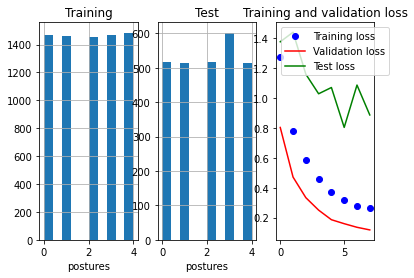

84/84 - 0s - loss: 0.8875 - accuracy: 0.7159

Test accuracy: 0.7159474492073059


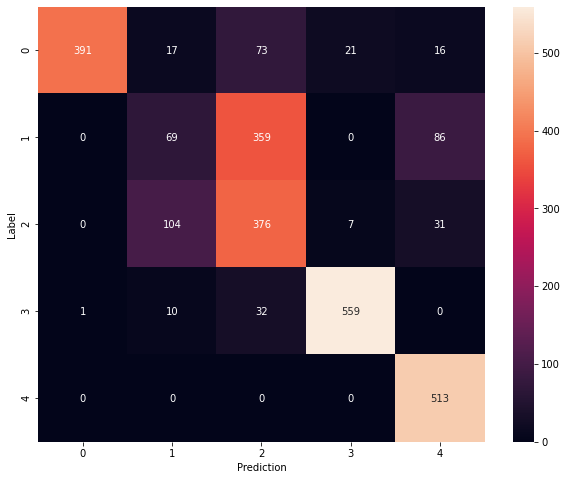

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_31 (Flatten)         (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 60)                780       
_________________________________________________________________
dropout_62 (Dropout)         (None, 60)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                915       
_________________________________________________________________
dropout_63 (Dropout)         (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 1,775
Trainable params: 1,775
Non-trainable params: 0
___________________________________________________

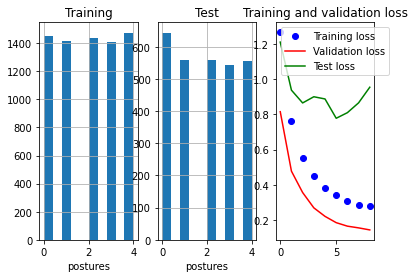

90/90 - 0s - loss: 0.9534 - accuracy: 0.7165

Test accuracy: 0.7165327072143555


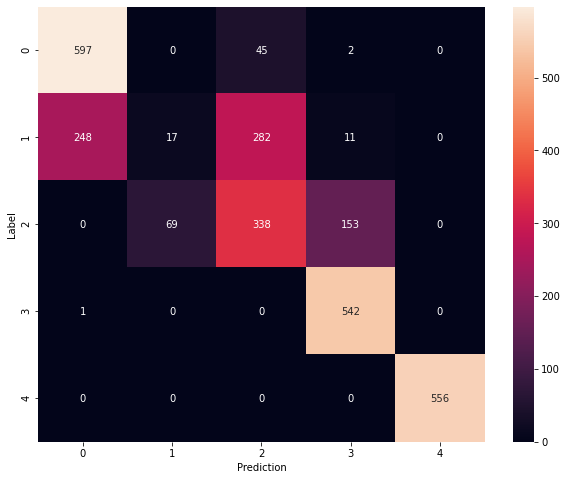

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_32 (Flatten)         (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 60)                780       
_________________________________________________________________
dropout_64 (Dropout)         (None, 60)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                915       
_________________________________________________________________
dropout_65 (Dropout)         (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 1,775
Trainable params: 1,775
Non-trainable params: 0
___________________________________________________

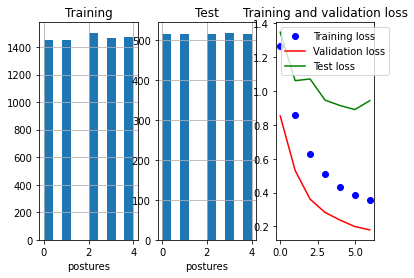

81/81 - 0s - loss: 0.9424 - accuracy: 0.6857

Test accuracy: 0.6856810450553894


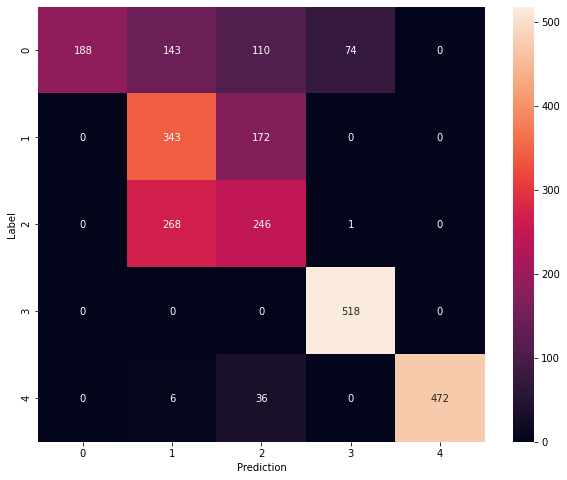

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_33 (Flatten)         (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 60)                780       
_________________________________________________________________
dropout_66 (Dropout)         (None, 60)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                915       
_________________________________________________________________
dropout_67 (Dropout)         (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 1,775
Trainable params: 1,775
Non-trainable params: 0
___________________________________________________

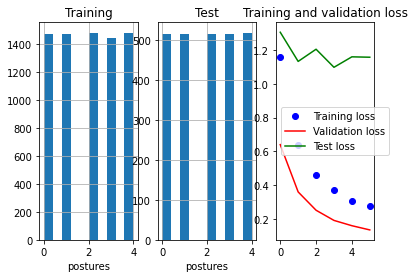

81/81 - 0s - loss: 1.1572 - accuracy: 0.5590

Test accuracy: 0.5589604377746582


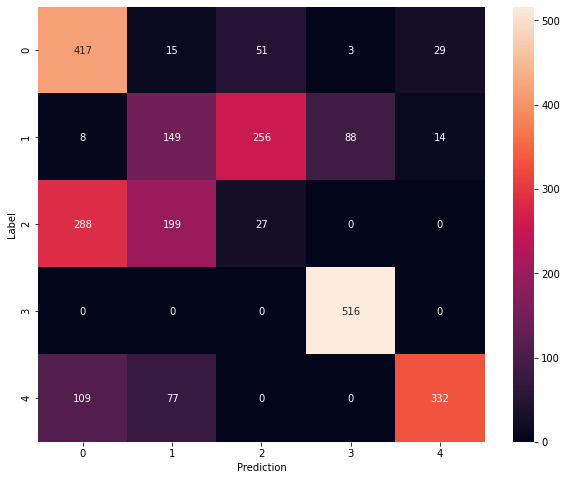

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_34 (Flatten)         (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 60)                780       
_________________________________________________________________
dropout_68 (Dropout)         (None, 60)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                915       
_________________________________________________________________
dropout_69 (Dropout)         (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 1,775
Trainable params: 1,775
Non-trainable params: 0
___________________________________________________

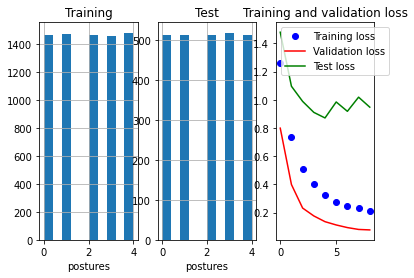

81/81 - 0s - loss: 0.9473 - accuracy: 0.6881

Test accuracy: 0.6880590915679932


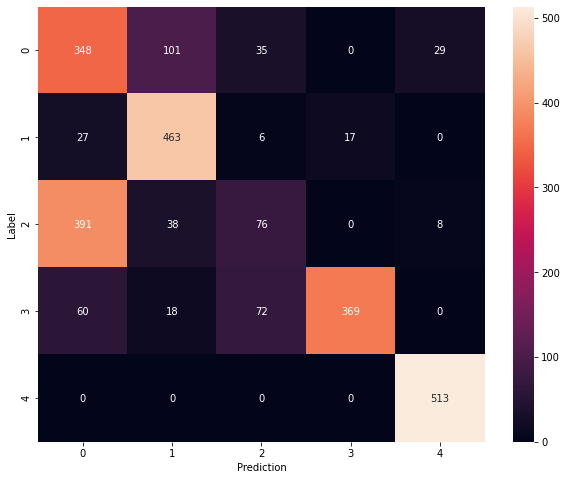

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_35 (Flatten)         (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 60)                780       
_________________________________________________________________
dropout_70 (Dropout)         (None, 60)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                915       
_________________________________________________________________
dropout_71 (Dropout)         (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 1,775
Trainable params: 1,775
Non-trainable params: 0
___________________________________________________

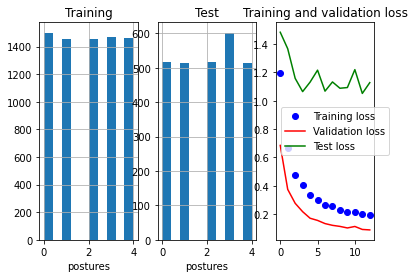

84/84 - 0s - loss: 1.1276 - accuracy: 0.6976

Test accuracy: 0.6975609660148621


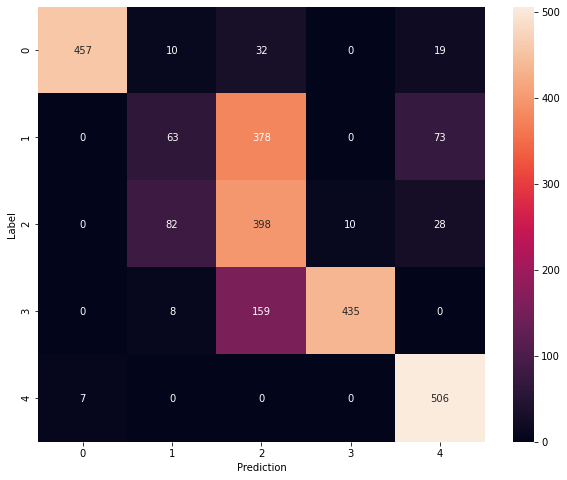

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_36 (Flatten)         (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 60)                780       
_________________________________________________________________
dropout_72 (Dropout)         (None, 60)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                915       
_________________________________________________________________
dropout_73 (Dropout)         (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 1,775
Trainable params: 1,775
Non-trainable params: 0
___________________________________________________

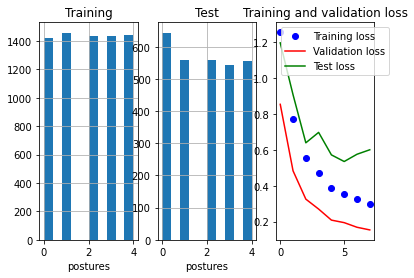

90/90 - 0s - loss: 0.6008 - accuracy: 0.7490

Test accuracy: 0.749038815498352


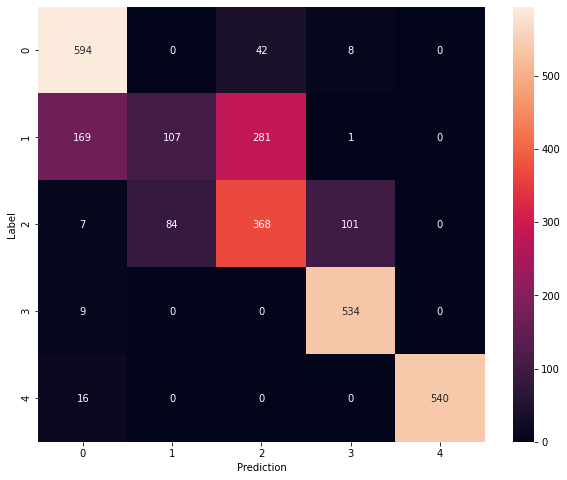

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_37 (Flatten)         (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 60)                780       
_________________________________________________________________
dropout_74 (Dropout)         (None, 60)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                915       
_________________________________________________________________
dropout_75 (Dropout)         (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 1,775
Trainable params: 1,775
Non-trainable params: 0
___________________________________________________

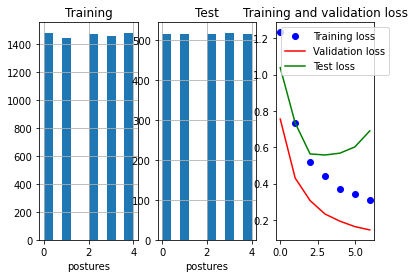

81/81 - 0s - loss: 0.6899 - accuracy: 0.7660

Test accuracy: 0.7660070061683655


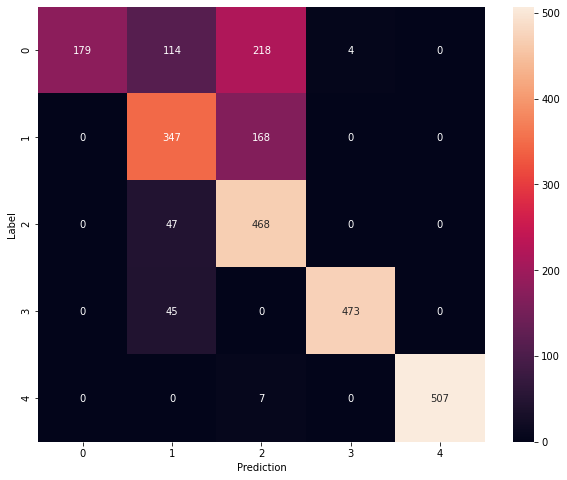

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_38 (Flatten)         (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 60)                780       
_________________________________________________________________
dropout_76 (Dropout)         (None, 60)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                915       
_________________________________________________________________
dropout_77 (Dropout)         (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 1,775
Trainable params: 1,775
Non-trainable params: 0
___________________________________________________

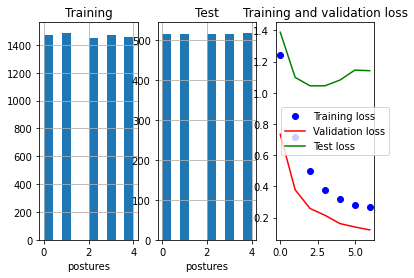

81/81 - 0s - loss: 1.1418 - accuracy: 0.5877

Test accuracy: 0.5876648426055908


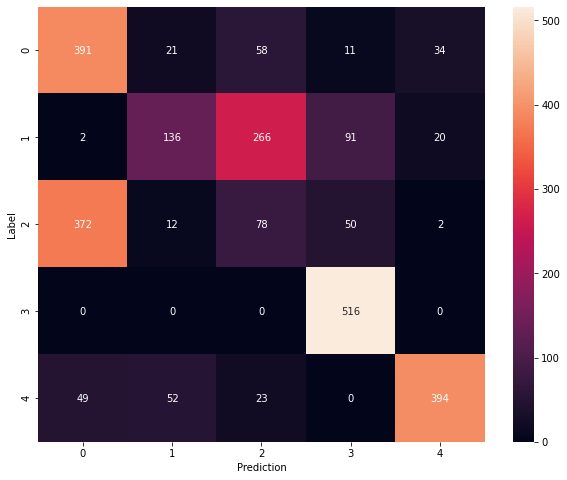

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_39 (Flatten)         (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 60)                780       
_________________________________________________________________
dropout_78 (Dropout)         (None, 60)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                915       
_________________________________________________________________
dropout_79 (Dropout)         (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 1,775
Trainable params: 1,775
Non-trainable params: 0
___________________________________________________

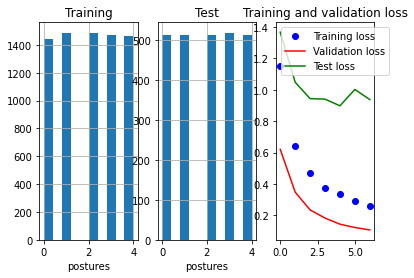

81/81 - 0s - loss: 0.9375 - accuracy: 0.7277

Test accuracy: 0.7277324199676514


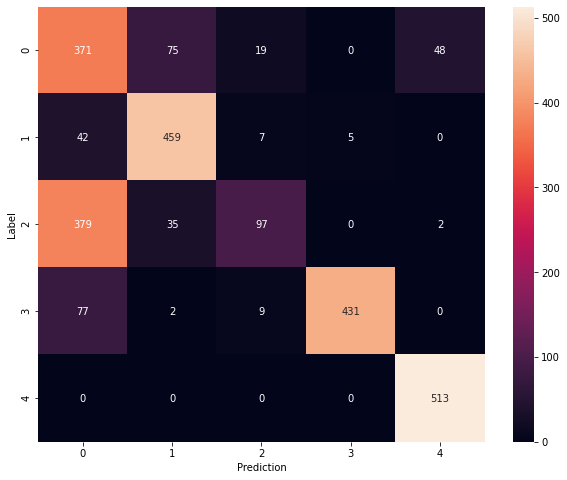

In [12]:
#########################################################################################################################################################################
#   This block of code is for trying different model configurations and seeing what works best
#########################################################################################################################################################################

Save_Performance = False
Custom_Learn_Rate = False
Verbose = 2 
Visualize = True

#Affects the range of layers that the models will have and how much times we want to test that setup
layer_1_itr = 1       #how much different first layer sizes to try
layer_2_itr = 1       #how much different second layer sizes to try
test_per_config = 10   #use multiple of total datasets

hidden_layer_1 = 60
hidden_layer_2 = 15
hidden_layer_1_interval = 5
hidden_layer_2_interval = 5

starting_num_epochs = 30

dropout_percent = 0.2
callback_patience=2
decay_rate = 0.90
decay_steps = 200

saved_metric_name = 'Model_Creation_01' #A file under this name will be saved containing the performance of different model configurations
#########################################################################################################################################################################

#Only for telling us how much more models will be tested
curr_run = 0
total_run = layer_1_itr*layer_2_itr*test_per_config 


test_history = pd.DataFrame(columns=['Accuracy','Layer 1','Layer 2','Dropout %','Average of','Patience','IN Learning Rate','decay_rate','decay_steps'])#stores performance stats
for i in range(0,layer_1_itr):
  for j in range(0,layer_2_itr):
    average_accuracy = 0;
    for k in range(0,test_per_config):
      get_data(curr_run%5)
      if Visualize: #to verify data being passed through looks good
        plt.subplot(1,3,1)
        y_train.hist() #displays the histogram based on posture
        plt.title("Training")
        plt.xlabel('postures')
        plt.subplot(1,3,2)
        y_val_test.hist()
        plt.title("Test")
        plt.xlabel('postures')

      initial_learning_rate = (hidden_layer_1+i*hidden_layer_1_interval)/10000

      #Creates the model structure and chooses the activation function for each layer
      model = tf.keras.Sequential([                      
          tf.keras.layers.Flatten(input_shape=(12,1)),
          tf.keras.layers.Dense(hidden_layer_1+i*hidden_layer_1_interval, activation='relu', name= "Layer_1"),  #hidden layers are generally: relu, sigmoid, tanh (Usually constant for all hidden layers)
          tf.keras.layers.Dropout(dropout_percent), #dropouts only occur during training
          tf.keras.layers.Dense(hidden_layer_2+j*hidden_layer_2_interval, activation='relu', name= "Layer_2"),  
          tf.keras.layers.Dropout(dropout_percent),
          tf.keras.layers.Dense(5, activation='linear', name= "Predicted_Posture"), #output layers are generally: linear, sigmoid, softmax
      ])

      if Visualize:
        model.summary()

      #Stops the model training early to prevent overfitting
      callbacks = [
      tf.keras.callbacks.EarlyStopping(# Stop training when `val_loss` is no longer improving
          monitor="val_accuracy",
          # min_delta=callback_delta,
          mode='auto',
          patience=callback_patience,# "no longer improving" being further defined as "for at least x epochs"
          verbose=1,
        )
      ] 

      #Adds the x_val dataset to be tested 
      val_test = AdditionalValidationSets([(x_val, y_val, 'val2')])

      #Saves the models when the accuracy is highest based on the test values
      checkpoint_path = "training_"+str(curr_run)+"/cp.ckpt"
      checkpoint_dir = os.path.dirname(checkpoint_path)
      cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor="val_accuracy",mode= "auto",save_best_only=True,save_weights_only=True,verbose=Verbose)

      #Assign type of: optimizer, loss, and metric
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)
      opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
      model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

      #Print out which loop we are undergoing
      print(str(curr_run)+" out of "+str(total_run) + " runs")

      #Train the model with the training data and save the stats in history
      history = model.fit(x_train,y_train,epochs=starting_num_epochs,callbacks = [val_test,callbacks,cp_callback],validation_data=(x_val_test, y_val_test),shuffle = True, verbose= Verbose)

      if Visualize:#Plots the training vs validation loss
        loss = history.history['loss']
        test_loss = history.history['val_loss']
        val_loss = val_test.history['val2_loss']
        epochs = history.epoch
        plt.subplot(1,3,3)
        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.plot(epochs, test_loss, 'g', label='Test loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()

      
      test_loss, test_acc = model.evaluate(x_val_test,  y_val_test, verbose=Verbose)
      if Verbose!=0: #Test the model with unseen data and record the settings
        print('\nTest accuracy:', test_acc)

      if Visualize:
        #create a confusion matrix to see model performance
        predictions = model.predict(x_val_test)
        predictions = np.argmax(predictions,axis = 1)
        confusion_mtx = tf.math.confusion_matrix(
            y_val_test, predictions, 5, weights=None, dtype=tf.dtypes.int32,
            name='PCD_Confusion_Matrix'
        )
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_mtx,annot=True, fmt='g')
        plt.xlabel('Prediction')
        plt.ylabel('Label')
        plt.show()
      average_accuracy = average_accuracy + test_acc
      curr_run = curr_run + 1

    #Records the test results for specific model configuration
    average_accuracy = average_accuracy/test_per_config
    new_row = {'Accuracy':average_accuracy,'Layer 1':hidden_layer_1+i*hidden_layer_1_interval,'Layer 2':hidden_layer_2+j*hidden_layer_2_interval,'Dropout %':dropout_percent,
               'Average of':test_per_config,'Patience':callback_patience,'IN Learning Rate':initial_learning_rate,'decay_rate':decay_rate,'decay_steps':decay_steps}
    test_history = test_history.append(new_row, ignore_index=True)

#Saves performance data
if Save_Performance:
  test_history.to_csv(saved_metric_name+".csv",index=False)
  from google.colab import files
  files.download(saved_metric_name+".csv")
#########################################################################################################################################################################

# **TESTING MODELS**


*Select the specific traing_x model that you want to reload*


In [26]:
def softmax(x):
    ex = np.exp(x)
    sum_ex = np.sum( np.exp(x))
    return ex/sum_ex

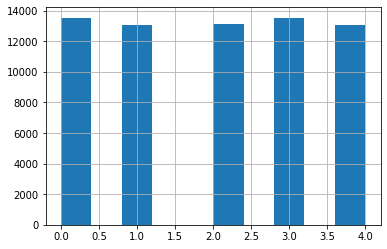

In [14]:
  data_arr = ['data_n01','data_n02','data_n03','data_n04','data_n05']
  test_data_01 = data_arr[0]
  test_data_02 = data_arr[1]
  test_data_03 = data_arr[2]
  test_data_04 = data_arr[3]
  test_data_05 = data_arr[4]

  #Initialize dataframes for storing the data and combine them 
  test_data1 = pd.read_csv(test_data_01+'.csv')
  test_data2 = pd.read_csv(test_data_02+'.csv')
  test_data3 = pd.read_csv(test_data_03+'.csv')
  test_data4 = pd.read_csv(test_data_04+'.csv')
  test_data5 = pd.read_csv(test_data_05+'.csv')
  test_data_combined = pd.concat([test_data1,test_data2,test_data3,test_data4,test_data5],ignore_index=True)
  test_data_combined.Class.hist()

  test_label = test_data_combined.pop("Class")
  test_data_combined = test_data_combined/180
  

In [15]:
# Loads the weights
model.load_weights("training_7/cp.ckpt")

# Re-evaluate the model
loss, acc = model.evaluate(test_data_combined, test_label, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

2071/2071 - 2s - loss: 0.2701 - accuracy: 0.9117
Restored model, accuracy: 91.17%


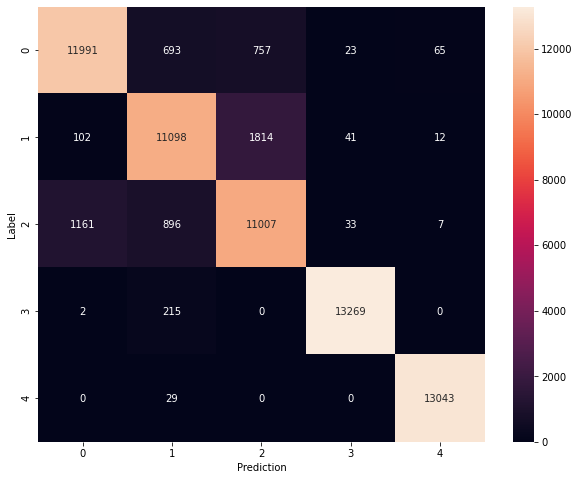

In [16]:
predictions = model.predict(test_data_combined)
predictions = np.argmax(predictions,axis = 1)
confusion_mtx = tf.math.confusion_matrix(
    test_label, predictions, 5, weights=None, dtype=tf.dtypes.int32,
    name='PCD_Confusion_Matrix'
)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [22]:
x_val_test[1:2]

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
1,-0.029,-0.059222,-0.156444,0.5005,0.069222,0.182833,-0.055056,-0.148278,0.084944,0.786556,-0.194778,0.059444


In [20]:
predictions = model.predict(x_val_test[1:2])
predictions = softmax(predictions)
predictions = predictions*100
np.round(predictions,3)

array([[13.031, 14.522, 72.008,  0.193,  0.245]], dtype=float32)

# **CONVERTING THE MODEL**

In [23]:
#########################################################################################################################################################################
#   Optimize the model for size and convert to tflite model
#########################################################################################################################################################################

#Covert the model to a tflite model & optimize to reduce the size
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

#########################################################################################################################################################################

INFO:tensorflow:Assets written to: /tmp/tmp5py8tsht/assets


9184

In [24]:
#########################################################################################################################################################################
#   Function to convert tflite file to C header file
#########################################################################################################################################################################

# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

#########################################################################################################################################################################

In [25]:
#########################################################################################################################################################################
#   Convert to c-header file via function
#########################################################################################################################################################################

# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))

#########################################################################################################################################################################